# Announcement-on-ML
<a href='http://www.kgptalkie.com' target="_blank"> <img src='https://github.com/laxmimerit/Important-Announcement-on-ML/raw/master/kgptalkie_strips.png'/></a>

# ML Resources
|  ML Course | Description |
|:---|:---|
| [**Fine Tuning LLM with HuggingFace Transformers for NLP**](https://www.udemy.com/course/fine-tuning-llm-with-hugging-face-transformers/?referralCode=6DEB3BE17C2644422D8E) | Learn how to fine tune LLM with custom dataset. You will learn basics of transformers then fine tune LLM|
| [**Data Visualization in Python Masterclass™: Beginners to Pro**](https://bit.ly/udemy95off_kgptalkie) |  Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Python for Machine Learning: A Step-by-Step Guide**](https://bit.ly/ml-ds-project) | Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Deep Learning for Beginners with Python**](https://bit.ly/dl-with-python) | Neural Networks, TensorFlow, ANN, CNN, RNN, LSTM, Transfer Learning and Much More. |
| [**Python for Linear Regression in Machine Learning**](https://bit.ly/regression-python) | Learn to build Linear Regression models using Python and its libraries like Scikit-Learn. |
| [**Introduction to Spacy 3 for Natural Language Processing**](https://bit.ly/spacy-intro) | Learn to build Natural Language Processing models using Python and its libraries like Spacy. |
| [**Advanced Machine Learning and Deep Learning Projects**](https://bit.ly/kgptalkie_ml_projects) | Learn to build Advanced Machine Learning and Deep Learning models using Python and transformer models like BERT, GPT-2, and XLNet. |
| [**Natural Language Processing in Python for Beginners**](https://bit.ly/intro_nlp) | Learn to build Natural Language Processing Projects using Spacy, NLTK, and Gensim, and transformer models like BERT, GPT-2, and XLNet. |
| [**Deployment of Machine Learning Models in Production in Python**](https://bit.ly/bert_nlp) |  Learn to deploy Machine Learning and Deep Learning models using Python and its libraries like HuggingFace Transformers, Streamlit, FastAPI, Docker and NGINX|
| [**R 4.0 Programming for Data Science - Beginners to Pro**](https://bit.ly/r4-ml) | Learn to build Machine Learning and Deep Learning models using R and its libraries like caret, tidyverse, and keras. |


## Disaster Tweets Classification using TinyBERT

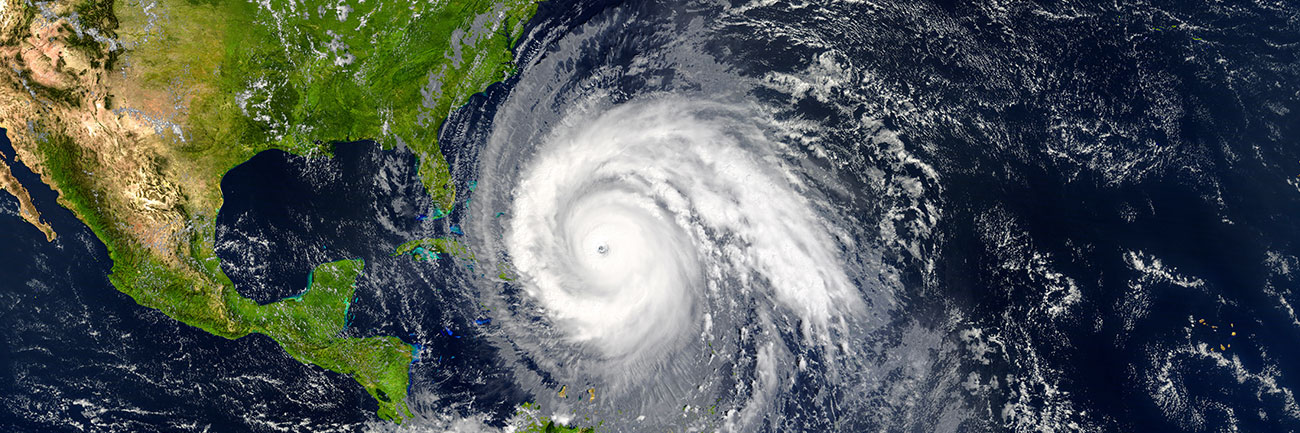

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

Kaggle hosted a challenge named Real or Not whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about real disaster against the ones talking about it metaphorically.

# `BERT` and `TinyBERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

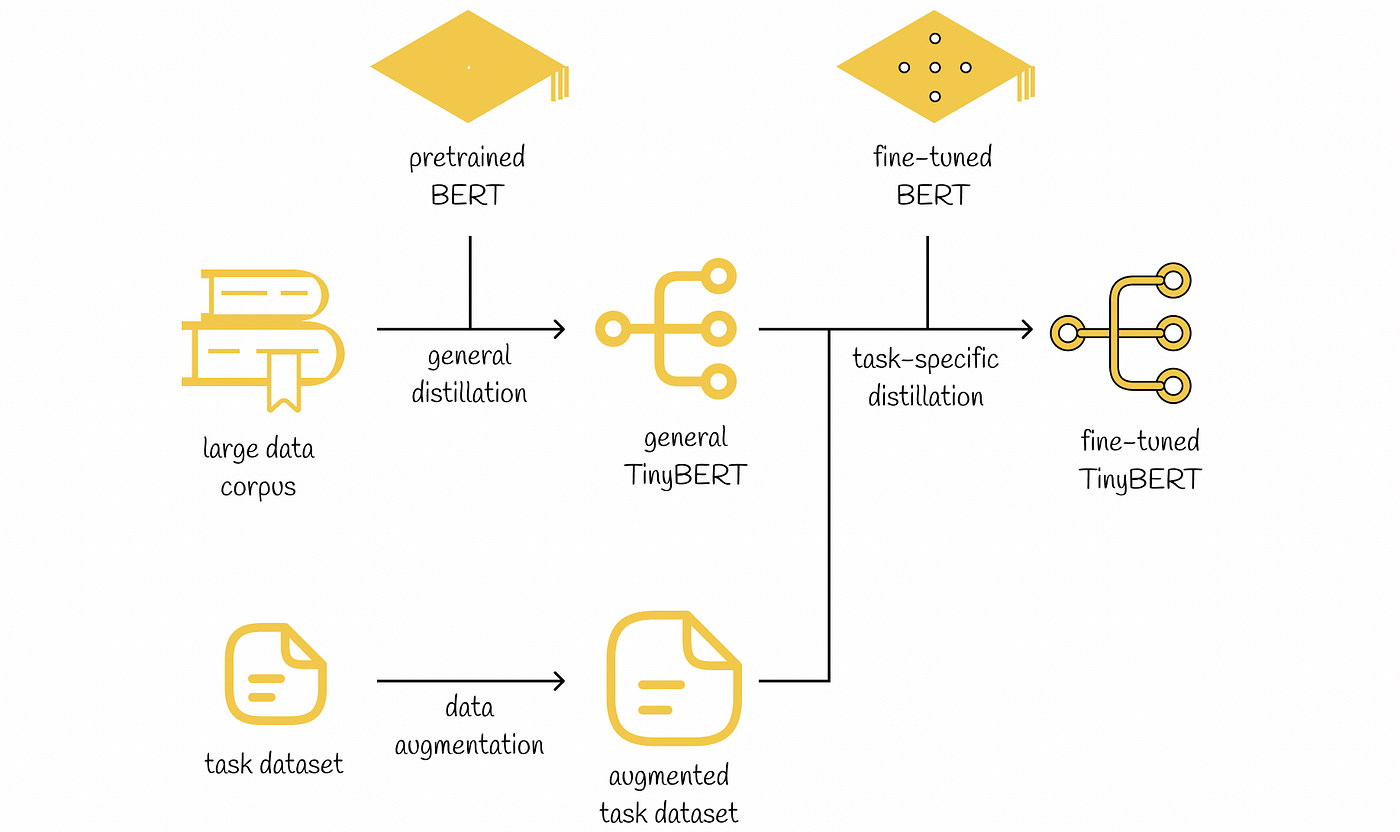

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.
- TinyBERT is distilled version of BERT. It uses 4 encoder layers and has 312 embedding size.
- Its easy to train and give high accuracy

# Disaster or General Tweets Classifications

## Download Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd



In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_disaster_tweets.csv", usecols=['text', 'target'])

df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df.isnull().sum()

df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<AxesSubplot:>

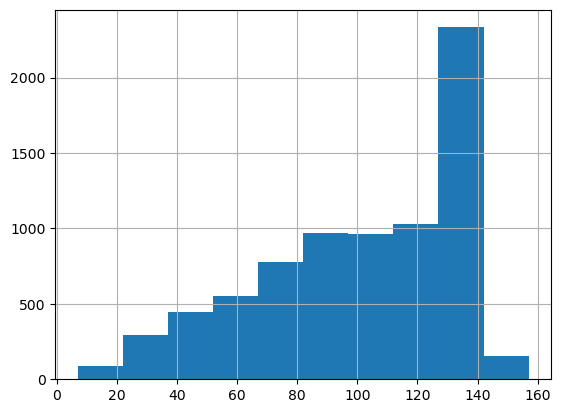

In [15]:
# case, un-cased
# context window -> 512 tokens
# 1 token -> 3char

df['text'].str.len().hist() #-> 160/3 => 53 => 60 tokens




### Load Data with Hugging Face Datasets Library


In [18]:
df = df.rename(columns={'target': 'label'})

In [20]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2)

dataset['train'][0]

{'text': 'Talk on GOZ is fantastic. Most interesting fact so far is that they manually bought all the .ru domains to sinkhole rather than seek co-op.',
 'label': 0}

In [21]:
id2label = {0:'general', 1: 'disaster'}
label2id = {'general': 0, 'disaster': 1}


## Data Tokenization


In [23]:
from transformers import AutoTokenizer
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)


In [25]:
tokenizer(dataset['train'][0]['text'])

def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=100)
    return temp

dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})

## Building Model Evaluation Functions
https://huggingface.co/docs/transformers/v4.42.0/en/tasks/sequence_classification#evaluate

In [27]:
# !pip install evaluate

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Model Building


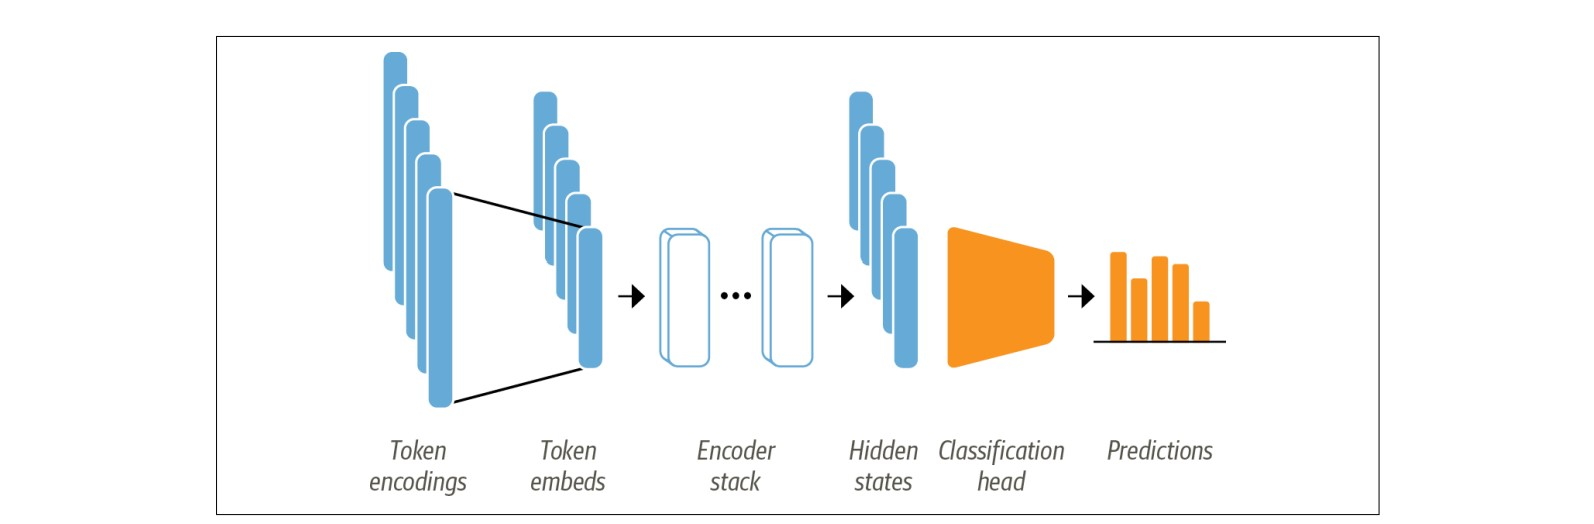

In [29]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), label2id=label2id, id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
args = TrainingArguments(
    output_dir='train_dir',
    overwrite_output_dir=True,
    num_train_epochs=5,
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

In [33]:
trainer.train()

  0%|          | 0/955 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.5070951581001282, 'eval_accuracy': 0.7839789888378201, 'eval_runtime': 0.9786, 'eval_samples_per_second': 1556.226, 'eval_steps_per_second': 49.047, 'epoch': 1.0}


  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.46242502331733704, 'eval_accuracy': 0.7997373604727511, 'eval_runtime': 0.982, 'eval_samples_per_second': 1550.933, 'eval_steps_per_second': 48.88, 'epoch': 2.0}
{'loss': 0.5126, 'grad_norm': 3.6246635913848877, 'learning_rate': 4.764397905759163e-06, 'epoch': 2.62}


  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.4610497057437897, 'eval_accuracy': 0.8003939592908733, 'eval_runtime': 0.9504, 'eval_samples_per_second': 1602.456, 'eval_steps_per_second': 50.504, 'epoch': 3.0}


  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.4416414499282837, 'eval_accuracy': 0.8049901510177282, 'eval_runtime': 0.7497, 'eval_samples_per_second': 2031.424, 'eval_steps_per_second': 64.024, 'epoch': 4.0}


  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.4375808835029602, 'eval_accuracy': 0.8108995403808273, 'eval_runtime': 0.9292, 'eval_samples_per_second': 1639.054, 'eval_steps_per_second': 51.658, 'epoch': 5.0}
{'train_runtime': 53.8395, 'train_samples_per_second': 565.57, 'train_steps_per_second': 17.738, 'train_loss': 0.46673791695639727, 'epoch': 5.0}


TrainOutput(global_step=955, training_loss=0.46673791695639727, metrics={'train_runtime': 53.8395, 'train_samples_per_second': 565.57, 'train_steps_per_second': 17.738, 'total_flos': 69927811858800.0, 'train_loss': 0.46673791695639727, 'epoch': 5.0})

In [34]:
trainer.evaluate()

  0%|          | 0/48 [00:00<?, ?it/s]

{'eval_loss': 0.4375808835029602,
 'eval_accuracy': 0.8108995403808273,
 'eval_runtime': 0.7855,
 'eval_samples_per_second': 1938.984,
 'eval_steps_per_second': 61.11,
 'epoch': 5.0}

## Model Save and Load for Inference


In [35]:
trainer.save_model('tinybert-disaster-tweet')

In [37]:
from transformers import pipeline
import torch

# data = ['this movie was horrible, the plot was really boring. acting was okay',
#         'the movie is really sucked. there is not plot and acting was bad',
#         'what a beautiful movie. great plot. acting was good. will see it again']

data = ['There is a fire in the building', 'I am happy today', 'I am sad today', 
          'I am not feeling well','There is a flood in the city, go to higher ground']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

classifier = pipeline('text-classification', model='tinybert-disaster-tweet', device=device)

classifier(data)

[{'label': 'disaster', 'score': 0.8494884371757507},
 {'label': 'general', 'score': 0.8829398155212402},
 {'label': 'general', 'score': 0.8765496015548706},
 {'label': 'general', 'score': 0.8841749429702759},
 {'label': 'disaster', 'score': 0.8661732077598572}]

## Push Model to AWS S3

In [38]:
# upload model folder to s3 bucket ml-models/tinybert-sentiment-analysis
import os
import boto3

s3 = boto3.client('s3')
bucket_name = 'mlops-kgptalkie'

def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")
            
            s3.upload_file(file_path, bucket_name, s3_key)


upload_directory('tinybert-disaster-tweet', 'ml-models/tinybert-disaster-tweet')